In [1]:
import torch
import torchvision
import matplotlib.pyplot as plt
import torch.nn.functional as F
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as T
from torch.utils.data import sampler

In [2]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
dtype = torch.float32

device

device(type='cpu')

In [3]:
transform = T.Compose([
                T.ToTensor(),
                T.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
            ])

inv_transform = T.Compose([
                T.Normalize((0., 0., 0.), (1/0.2023, 1/0.1994, 1/0.2010)),
                T.Normalize((-0.4914, -0.4822, -0.4465), (1., 1. ,1. )),
                T.ToPILImage()
            ])


NUM_TRAIN = 49000

ds_train = torchvision.datasets.CIFAR10('./', train=True, download=True, transform=transform)
ds_test  = torchvision.datasets.CIFAR10('./', train=False, download=True, transform=transform)

dl_train = DataLoader(ds_train, batch_size=64, sampler=sampler.SubsetRandomSampler(range(0, NUM_TRAIN)))
dl_valid = DataLoader(ds_train, batch_size=64, sampler=sampler.SubsetRandomSampler(range(NUM_TRAIN, 50000)))
dl_test  = DataLoader(ds_test,  batch_size=64)

splits = {
    "train": dl_train,
    "valid": dl_valid,
    "test": dl_test,
}

Files already downloaded and verified
Files already downloaded and verified


mean: 0.06
std: 1.32
max: 2.75
min: -2.43


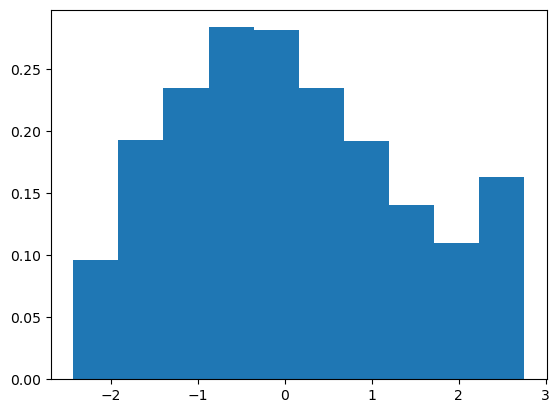

In [4]:
x, _ = next(iter(dl_train))
x = x.view(-1)
print(f"mean: {x.mean():.2f}")
print(f"std: {x.std():.2f}")
print(f"max: {x.max():.2f}")
print(f"min: {x.min():.2f}")

# hy, hx = torch.histogram(x, density=True)
# plt.plot(hx[:-1].detach(), hy.detach())
plt.hist(x, density=True);

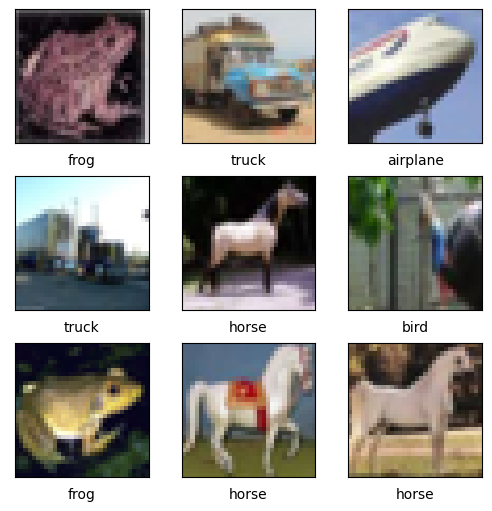

In [5]:
def plot_sample(xb, yb, pred=None):
    fig, axs = plt.subplots(3, 3, figsize=(5, 5), layout='constrained')

    for r in range(3):
        for c in range(3):
            ax = axs[r][c]
            x = xb[r*3 + c]
            y = yb[r*3 + c]
            x = inv_transform(x)
            ax.imshow(x)
            ax.set_xticks([])
            ax.set_yticks([])
            ax.set_xlabel(ds_train.classes[y])

            if pred != None:
                yh = pred[r*3 + c]
                ax.set_xlabel(ds_train.classes[yh])

                if yh != y:
                    ax.xaxis.label.set_color('r')

xb, yb = next(iter(dl_train))
plot_sample(xb, yb)

## Model

In [64]:
class CNN(nn.Module):

    def __init__(self):
        super().__init__()

        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1)
        nn.init.kaiming_normal_(self.conv1.weight, nonlinearity="relu")
        nn.init.zeros_(self.conv1.bias)

        self.conv2 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding=1)
        nn.init.kaiming_normal_(self.conv2.weight, nonlinearity="relu")
        nn.init.zeros_(self.conv2.bias)

        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(32*32*32, 32*32)
        nn.init.kaiming_normal_(self.fc1.weight, nonlinearity="relu")
        nn.init.zeros_(self.fc1.bias)

        self.fc2 = nn.Linear(32*32, 10)
        nn.init.zeros_(self.fc2.bias)

    def forward(self, x):
        self.h = [0] * 5
        self.h[0] = x

        y = self.conv1(x).relu()
        self.h[1] = y

        y = self.conv2(y).relu()
        self.h[2] = y

        y = self.flatten(y)
        y = self.fc1(y).relu()
        self.h[3] = y

        y = self.fc2(y)
        self.h[4] = y

        return y


model = CNN()
print(f"parameter count: {sum([p.numel() for p in model.parameters()]):,}")

parameter count: 33,575,850


## Sanity Check

Initial loss check

In [51]:
model = CNN()
xb, yb = next(iter(dl_train))
yh = model(xb)
loss = F.cross_entropy(yh, yb)
loss.backward()

print("chance:", -torch.tensor(1/10).log().item())
print("loss:", loss.item())

chance: 2.3025851249694824
loss: 2.5674588680267334


Check if model has the capacity of overfit a small batch

In [69]:
model = CNN()

xb, yb = next(iter(dl_train))
y = model(xb)
optimizer = torch.optim.AdamW(model.parameters())
xb, yb = next(iter(dl_train))

for i in range(1000):
    optimizer.zero_grad()
    yh = model(xb)
    loss = F.cross_entropy(yh, yb)
    loss.backward()
    optimizer.step()
    
    if i % 10 == 0:
        print(f"{loss.item():.4f}")

    if loss.item() < 1e-5:
        break

2.5203
0.9546
0.0323
0.0009
0.0001
0.0000


Activation distribution check

layer 0: mean +0.06, std 1.26, cut-off 0.52
layer 1: mean +0.73, std 1.23, cut-off 0.50
layer 2: mean +0.78, std 1.22, cut-off 0.48
layer 3: mean +0.81, std 1.24, cut-off 0.49
layer 4: mean -0.08, std 0.89, cut-off 0.57


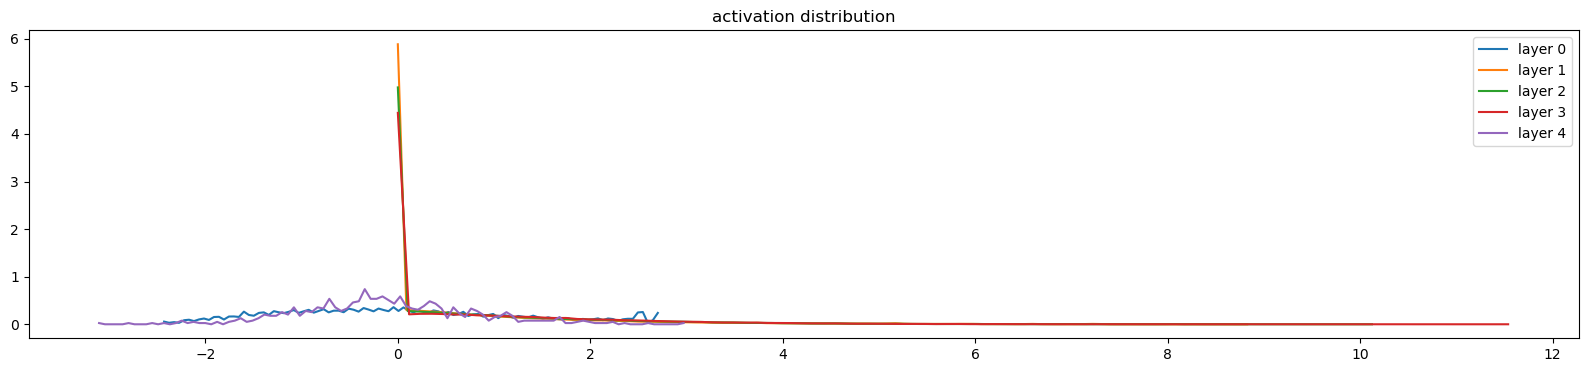

In [70]:
model = CNN()
xb, yb = next(iter(dl_train))
yh = model(xb)
loss = F.cross_entropy(yh, yb)
loss.backward()

plt.figure(figsize=(20, 4))
legends = []
for i, h in enumerate(model.h):
    print('layer %d: mean %+.2f, std %.2f, cut-off %.2f' % (i, h.mean(), h.std(), (h <= 0).to(dtype=torch.float).mean()))
    hy, hx = torch.histogram(h, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i}')

plt.legend(legends);
plt.title('activation distribution');

(0.7325654, 1.2317774)

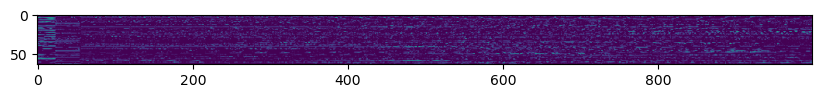

In [71]:
h1 = model.h[1].view(64, -1).detach().numpy()
h = h1[:, 1000:2000]
plt.figure(figsize=(10, 10))
plt.imshow(h)

h1.mean(), h1.std()

0 Conv: mean -0.0032, std 0.0208, zero: 0.2315%
1 Conv: mean +0.0081, std 0.0207, zero: 1.3563%
2 Line: mean +0.0002, std 0.0040, zero: 18.7637%
3 Line: mean +0.0000, std 0.1263, zero: 1.6016%


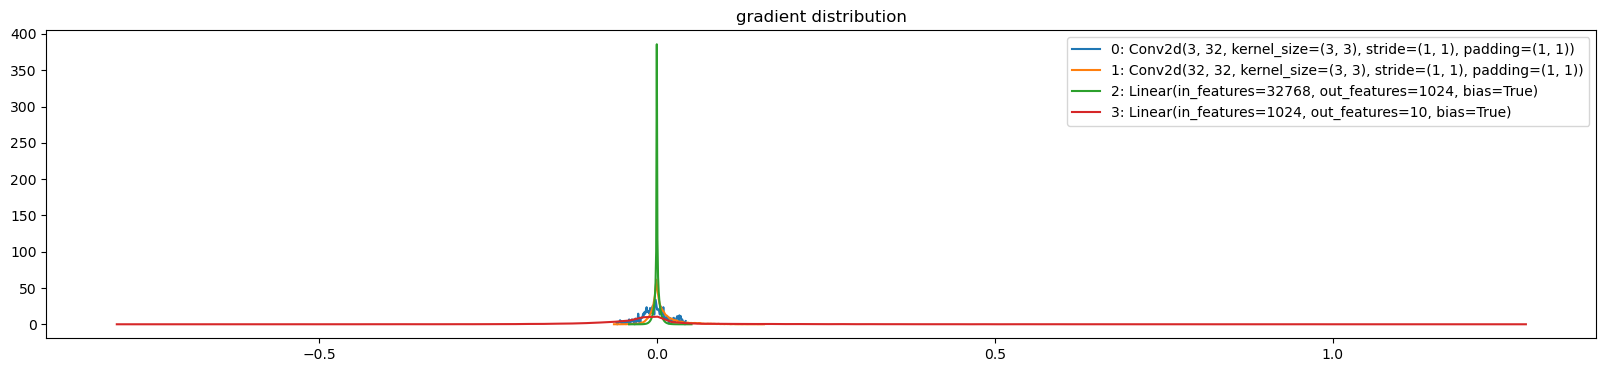

In [73]:
plt.figure(figsize=(20, 4))
legends = []
layers = [m for m in model.children() if "Conv" in str(m) or "Linear" in str(m)]

for i, m in enumerate(layers):
    t = m.weight.grad
    print('%d %s: mean %+.4f, std %.4f, zero: %.4f%%' % (i, str(m)[0:4], t.mean(), t.std(), (t.abs() < 0.0001).float().mean()*100))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'{i}: {str(m)}')

plt.legend(legends);
plt.title('gradient distribution');

## Training

In [74]:
@torch.no_grad()
def eval_split(split, model, sample_size=None):
    model.eval()
    dl = splits[split]

    num_correct = 0
    num_sample = 0
    lossi = []
    i = 0

    for xb, yb in dl:
        xb = xb.to(device=device, dtype=dtype)
        yb = yb.to(device=device)

        logits = model(xb)
        loss = F.cross_entropy(logits, yb)
        lossi.append(loss.item())

        _, idx = logits.max(1)
        num_correct += (yb == idx).sum()
        num_sample += len(yb)

        i += len(xb)
        if sample_size and i >= sample_size:
            break

    accuracy = float(num_correct) / num_sample
    loss = torch.tensor(lossi).mean().item()
    model.train()

    return loss, accuracy

In [75]:
@torch.no_grad()
def grad_ratio(param, lr):
    update = -lr * param.grad 
    return update.std() / param.std()

In [76]:
%%time

model = CNN()
model = model.to(device=device)
model.train()

dl = splits["train"]
epoch = 1
i = 0
n = len(dl) * epoch

metrics = []
update_ratio = []
optimizer = torch.optim.AdamW(model.parameters())

for _ in range(epoch):
    for xb, yb in dl:
        xb = xb.to(device=device, dtype=dtype)
        yb = yb.to(device=device)
        optimizer.zero_grad()

        logits = model(xb)
        loss = torch.nn.functional.cross_entropy(logits, yb)
        loss.backward()
        
        if i % 10 == 0:
            tr_loss, tr_acc = eval_split("train", model, sample_size=1024)
            va_loss, va_acc = eval_split("valid", model, sample_size=1024)
            # update_ratio = [grad_ratio(p) for p in model.parameters() if p.dim() == 2]
            metrics.append((tr_loss, tr_acc, va_loss, va_acc))
            print(f"{int(i/n*100)}%: {tr_loss:.2f} {va_loss:.2f} {tr_acc:.2f} {va_acc:.2f}")

        i += 1
        optimizer.step()

0%: 2.62 2.64 0.08 0.06
1%: 4.38 4.37 0.19 0.20
2%: 2.25 2.24 0.17 0.21
3%: 2.23 2.22 0.22 0.23
5%: 2.18 2.19 0.24 0.26
6%: 2.10 2.10 0.22 0.22
7%: 2.01 2.01 0.28 0.31
9%: 1.93 1.96 0.32 0.32
10%: 1.85 1.86 0.34 0.33
11%: 1.82 1.83 0.35 0.37
13%: 1.81 1.81 0.37 0.37
14%: 1.71 1.73 0.37 0.39
15%: 1.73 1.73 0.37 0.37
16%: 1.59 1.60 0.43 0.44
18%: 1.62 1.63 0.45 0.43
19%: 1.55 1.58 0.46 0.43
20%: 1.56 1.60 0.43 0.46
22%: 1.51 1.55 0.47 0.47
23%: 1.50 1.59 0.46 0.46
24%: 1.44 1.53 0.50 0.47
26%: 1.53 1.51 0.45 0.48
27%: 1.38 1.50 0.52 0.48
28%: 1.41 1.50 0.49 0.47
30%: 1.42 1.47 0.50 0.48
31%: 1.40 1.43 0.51 0.49
32%: 1.31 1.45 0.53 0.48
33%: 1.33 1.42 0.52 0.50
35%: 1.30 1.44 0.54 0.51
36%: 1.32 1.44 0.54 0.48
37%: 1.26 1.37 0.56 0.51
39%: 1.29 1.36 0.55 0.52
40%: 1.25 1.34 0.57 0.52
41%: 1.25 1.35 0.57 0.54
43%: 1.26 1.39 0.56 0.52
44%: 1.33 1.37 0.53 0.50
45%: 1.24 1.38 0.57 0.51
46%: 1.19 1.35 0.58 0.52
48%: 1.20 1.34 0.58 0.52
49%: 1.18 1.33 0.58 0.54
50%: 1.14 1.29 0.61 0.56
52%: 1.0

In [ ]:
# return average gradient
@torch.no_grad()
def grad_avg(module):
    params = [p.grad.mean() for p in module.parameters() if p.requires_grad and p.dim() > 1]
    # most layer only have one learnable
    return params[0].item()

@torch.no_grad()
def grad_std(module):
    params = [p.grad.std() for p in module.parameters() if p.requires_grad and p.dim() > 1]
    # most layer only have one learnable
    return params[0].item()

@torch.no_grad()
def grad_ratio(module):
    params = [p.grad.std() / p.std() for p in module.parameters() if p.requires_grad and p.dim() > 1]
    # most layer only have one learnable
    return params[0].item()

def layer_grad_avg(model):
    return [(str(layer)[0:4], grad_avg(layer), grad_std(layer), grad_ratio(layer)) for layer in model.children() if "Conv" in str(layer) or "Linear" in str(layer)]

layer_grad_avg(model)

In [77]:
tr_loss, tr_acc = eval_split("train", model)
va_loss, va_acc = eval_split("valid", model)

print(f"train: {tr_loss:.2f} {tr_acc:.2f}")
print(f"valid: {va_loss:.2f} {va_acc:.2f}")

train: 0.88 0.70
valid: 1.16 0.60


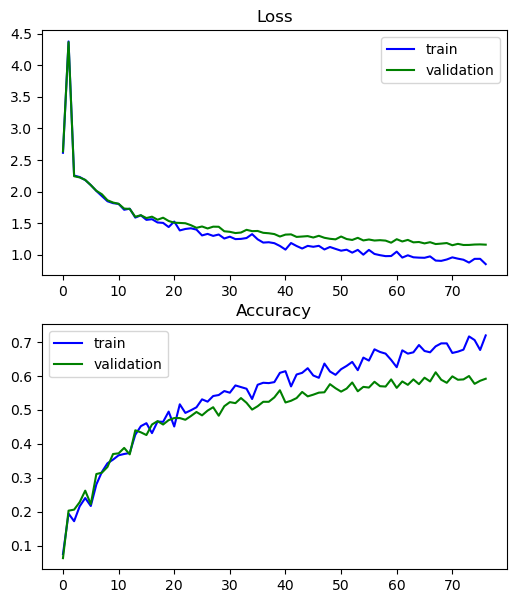

In [78]:
# plot loss and accuracy, one on left and another on the right
tr_loss, tr_acc, va_loss, va_acc = zip(*metrics)

plt.figure(figsize=(6, 7))

plt.subplot(2, 1, 1)
plt.plot(tr_loss, label="train", color="b")
plt.plot(va_loss, label="validation", color="g")
plt.title("Loss")
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(tr_acc, label="train", color="b")
plt.plot(va_acc, label="validation", color="g")
plt.title("Accuracy")
plt.legend()

In [80]:
@torch.no_grad()
def predict(x):
    model.eval()
    x = x.to(device=device, dtype=dtype)
    logits = model(x)
    prob = F.softmax(logits, dim=1)
    yh = torch.argmax(prob, dim=1)
    model.train()
    return yh

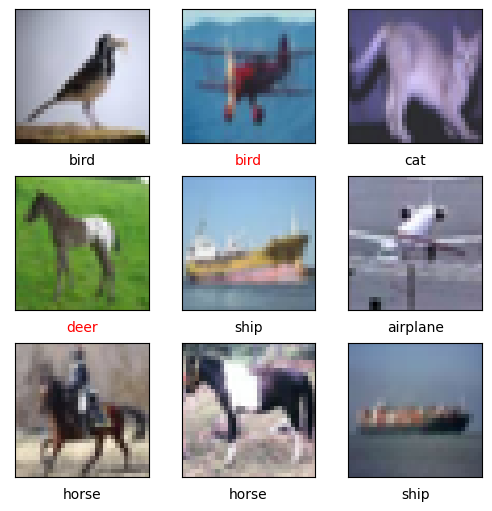

In [81]:
xb, yb = next(iter(dl_valid))
pred = predict(xb)

plot_sample(xb, yb, pred)

## Log

Basic
```
conv(32, 3x3, p=1)
conv(32, 3x3, p=1)
fc(32768, 1024)
fc(1024, 10)
count: 33,575,850
```
- train: 0.94 0.67
- valid: 1.10 0.61

With better init
- train: 0.88 0.70
- valid: 1.16 0.60